#Importing required modules


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
StopWords=set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Exploratory Data Analysis

In [ ]:
#load the dataset
df=pd.read_csv('amazon_alexa.tsv', delimiter='\t')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
#column names
print(f"column names: {df.columns.tolist()}")

column names: ['rating', 'date', 'variation', 'verified_reviews', 'feedback']


In [ ]:
# check for null values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [ ]:
#getting the record where value is null
df[df['verified_reviews'].isna()]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


Since there is no review we can drop this record

In [ ]:
#drop null values
df.dropna(inplace=True)

In [ ]:
#check duplicate rows
df.duplicated().sum()

715

In [ ]:
#drop duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
# check after droping null values
df.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [ ]:
#check after droping duplicate rows
df.duplicated().sum()

0

In [ ]:
#shape of dataset after droping null and duplicate records
print(f"Shape of dataset: {df.shape}")

Shape of dataset: (2434, 5)


In [ ]:
# creating a new column length that will contain the length of the string in verified_reviews column
df['length']=df['verified_reviews'].apply(len)
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


**Analysing Rating Column**

In [ ]:
# Distinct values of rating and its count
print(f"Distinct values of rating and its count:\n {df['rating'].value_counts()}")

Distinct values of rating and its count:
 rating
5    1756
4     345
1     141
3     113
2      79
Name: count, dtype: int64


Text(0.5, 1.0, 'Count plot for ratings')

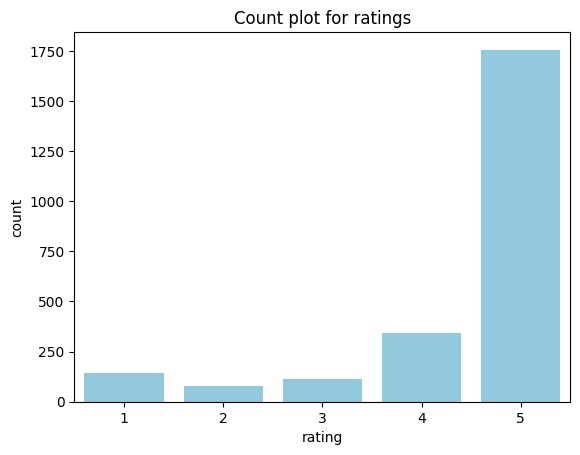

In [ ]:
# Count plot for distinct values of ratings
sns.countplot(x=df['rating'],color='skyblue')
plt.title("Count plot for ratings")

From the above plot it can be clearly seen that maximum number of ratings for this product is 5 star rating


In [ ]:
# Distinct values of rating and its percentage
print(f"Distinct values of rating and its percentage:\n {round((df['rating'].value_counts()/df.shape[0])*100,2)}")

Distinct values of rating and its percentage:
 rating
5    72.14
4    14.17
1     5.79
3     4.64
2     3.25
Name: count, dtype: float64


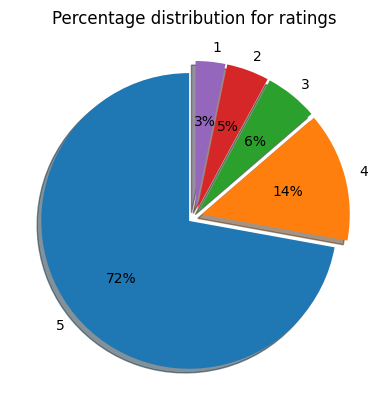

In [ ]:
#pie chart to show percentage distibution of ratings
plt.pie(df['rating'].value_counts(), labels=df['rating'].unique(),autopct='%1.0f%%',shadow=True,explode=[0.05,0.05,0.05,0.05,0.05],startangle=90)
plt.title('Percentage distribution for ratings')
plt.show()

**Analysing feedback column**

In [ ]:
# Distinct values of feedback and its count
print(f"Distinct values of feedback and its count:\n {df['feedback'].value_counts()}")

Distinct values of feedback and its count:
 feedback
1    2214
0     220
Name: count, dtype: int64


In [ ]:
#percentage distribution of feedback values
print(f"Percentage distribution of feedback values:\n {round((df['feedback'].value_counts()/df.shape[0])*100,2)}")



Percentage distribution of feedback values:
 feedback
1    90.96
0     9.04
Name: count, dtype: float64


In [ ]:
# checking verified review of any row when feedback is 0
review_0=df[df['feedback']==0]['verified_reviews'].iloc[1]
review_0

'Sound is terrible if u want good music too get a bose'

In [ ]:
# checking verified review of any row when feedback is 1
review_1=df[df['feedback']==1]['verified_reviews'].iloc[1]
review_1

'Loved it!'

It can be clearly seen above that when feedback is 0 then there is a negative review while when feedback is 1 then there is a positive review,therefore feedback will be our target column

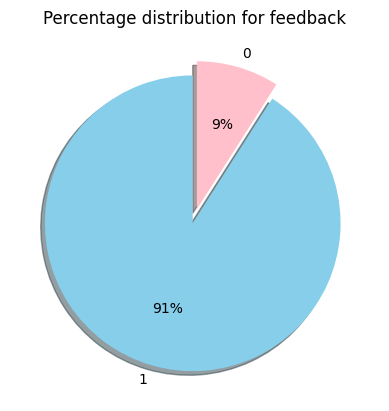

In [ ]:
# pie chart for feedback to show percentage distribution
plt.pie(df['feedback'].value_counts(), labels=df['feedback'].unique(),autopct='%1.0f%%',shadow=True,explode=[0.05,0.05],startangle=90, colors=['skyblue','pink'])
plt.title('Percentage distribution for feedback')
plt.show()

From the above pie chart it is clear that 91% of the total reviews are positive reviews

**Analysing variation column**

In [ ]:
# check distinct values of variation and its count
print(f"Distinct values of variation and its count:\n {df['variation'].value_counts()}")

Distinct values of variation and its count:
 variation
Configuration: Fire TV Stick    342
Black  Plus                     270
Black                           261
Black  Show                     260
Black  Dot                      252
Black  Spot                     241
Charcoal Fabric                 219
White  Spot                     108
White  Dot                       92
White                            90
White  Show                      85
Heather Gray Fabric              79
White  Plus                      78
Sandstone Fabric                 45
Oak Finish                        7
Walnut Finish                     5
Name: count, dtype: int64


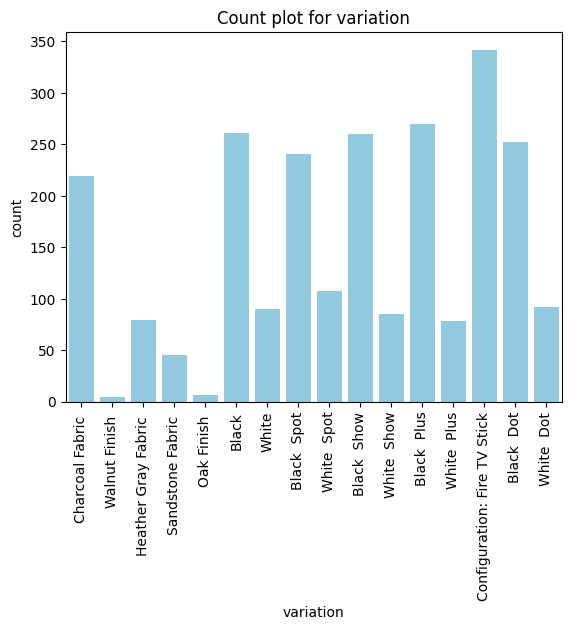

<Figure size 1500x1000 with 0 Axes>

In [ ]:
#countplot to visualize different variations and their counts
sns.countplot(x=df['variation'],color='skyblue')
plt.xticks(rotation=90)
plt.title("Count plot for variation")
plt.figure(figsize=(15,10))
plt.show()

In [ ]:
# check average rating for each variation
df.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.452381
Black  Plus                     4.370370
Black  Show                     4.480769
Black  Spot                     4.311203
Charcoal Fabric                 4.735160
Configuration: Fire TV Stick    4.590643
Heather Gray Fabric             4.696203
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.800000
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.342593
Name: rating, dtype: float64

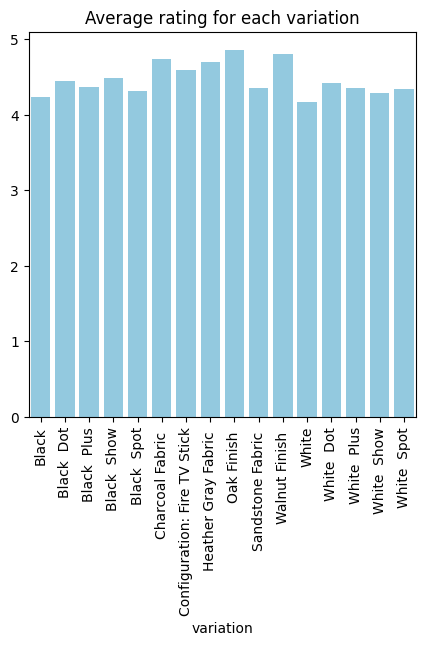

In [ ]:
# bar plot to visualize average rating for each variation
plt.figure(figsize=(5,5))
sns.barplot(x=df.groupby('variation')['rating'].mean().index,y=df.groupby('variation')['rating'].mean().values,color='skyblue')
plt.xticks(rotation=90)
plt.title("Average rating for each variation")
plt.show()

From the above bar plot its clear that average rating for each variation is around 4.5

**Analyzing verified_reviews column**

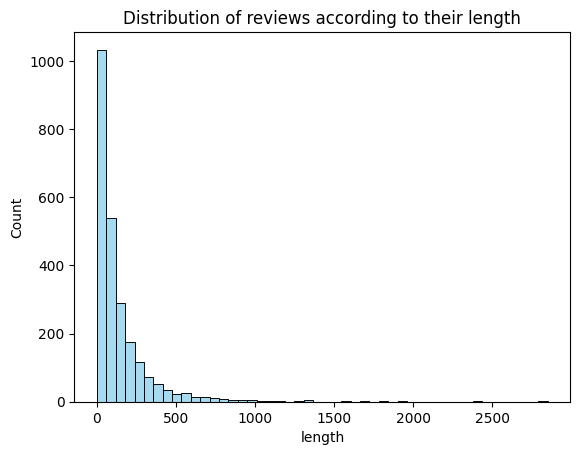

In [ ]:
# check distribution of reviews according to their length
sns.histplot(x=df['length'],color='skyblue',binwidth=60)
plt.title("Distribution of reviews according to their length")
plt.show()

From the above histogram it can be seen that maximum reviews are of length between 0-100 (approx)

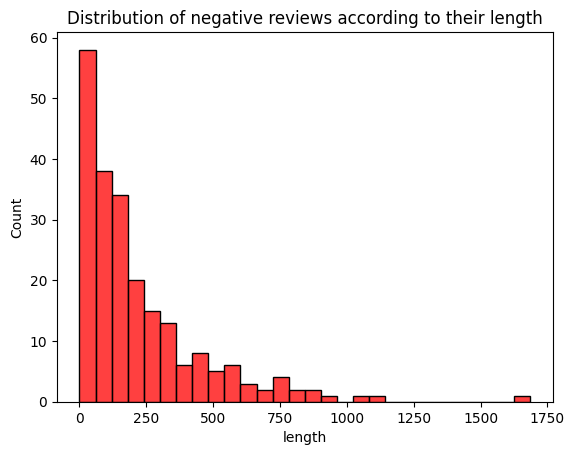

In [ ]:
# check distribution of reviews according to their length when feedback is 0
sns.histplot(x=df[df['feedback']==0]['length'],color='red',binwidth=60)
plt.title("Distribution of negative reviews according to their length")
plt.show()

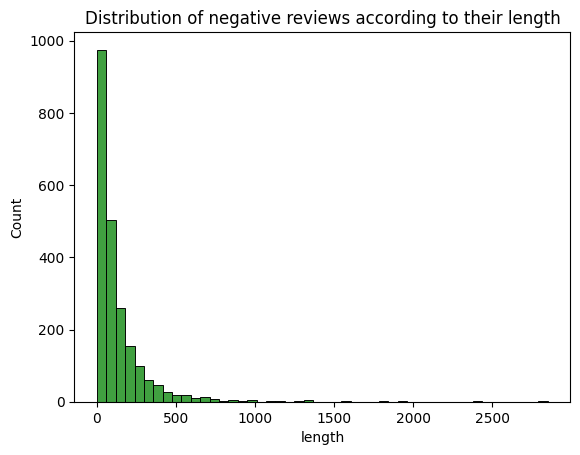

In [ ]:
# check distribution of reviews according to their length when feedback is 1
sns.histplot(x=df[df['feedback']==1]['length'],color='green',binwidth=60)
plt.title("Distribution of negative reviews according to their length")
plt.show()

From the above two plots it can be seen that negative reviews are usually shorter in length as compared to positive reviews.

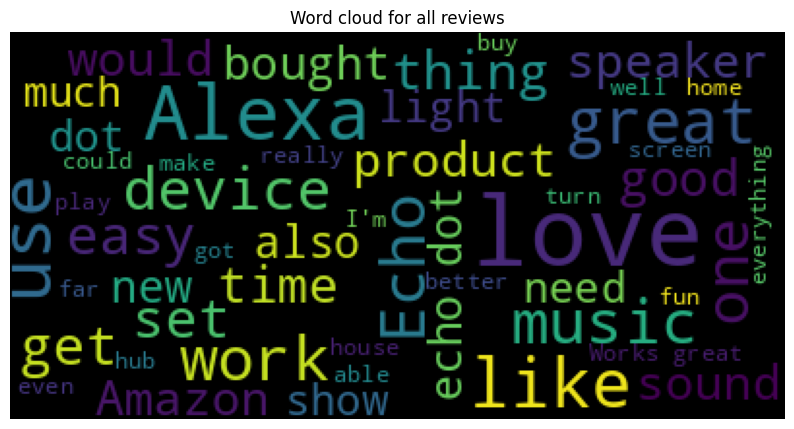

In [ ]:
# word cloud for all reviews

# combining all reviews
reviews=" ".join([ review for review in df['verified_reviews']])

#initialising word cloud
wc=WordCloud(background_color='black',max_words=50,max_font_size=50,stopwords=StopWords)

#generating word cloud
wc.generate(reviews)

#plotting word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.title("Word cloud for all reviews")
plt.show()


In [ ]:
#finding unique positive and negative reviews
positive_reviews=' '.join([review for review in df[df['feedback']==1]['verified_reviews']])
positive_reviews=positive_reviews.lower().split()
negative_reviews=' '.join([review for review in df[df['feedback']==0]['verified_reviews']])
negative_reviews=negative_reviews.lower().split()

unique_positive=' '.join([review for review in positive_reviews if review not in negative_reviews])
unique_negative=' '.join([review for review in negative_reviews if review not in positive_reviews])

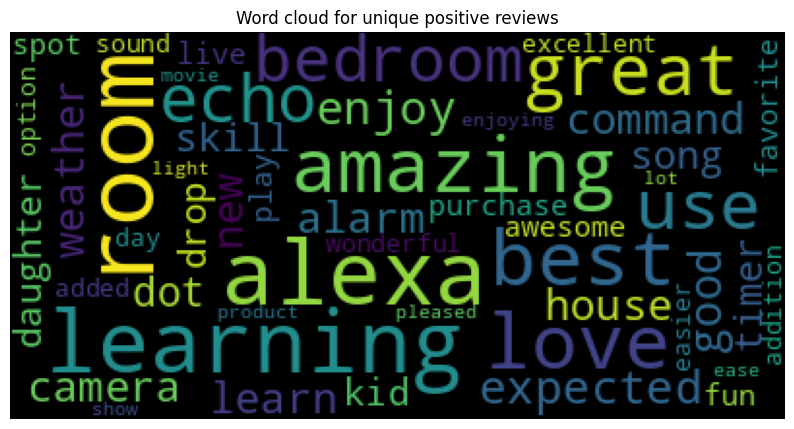

In [ ]:
#word cloud for unique positive reviews
wc=WordCloud(background_color='black',max_words=50,max_font_size=50,stopwords=StopWords)
wc.generate(unique_positive)
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.title("Word cloud for unique positive reviews")
plt.show()

positive words such as great,amazing,etc can be seen in above word cloud

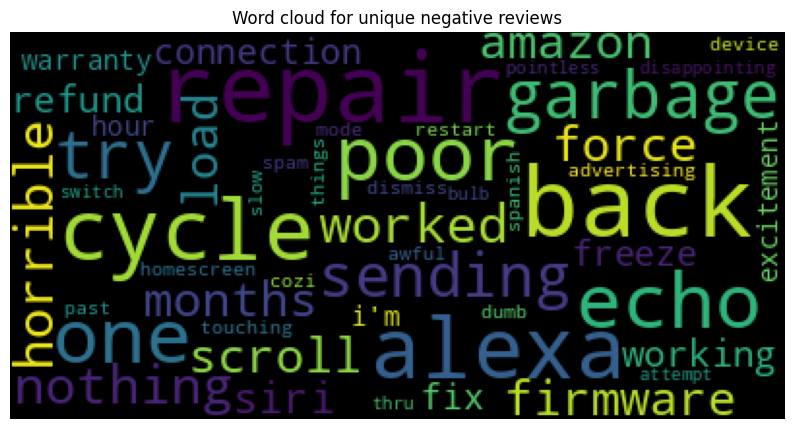

In [ ]:
# word cloud for unique negative reviews
wc=WordCloud(background_color='black',max_words=50,max_font_size=50,stopwords=StopWords)
wc.generate(unique_negative)
plt.figure(figsize=(10,10))
plt.imshow(wc)
plt.axis('off')
plt.title("Word cloud for unique negative reviews")
plt.show()

Negative words such as repair,garbage,etc can be seen from above word cloud

# Preprocessing and modelling
To build the corpus we perform the following steps:

1.   Replace any non alphabatical character with space.
2.   convert to lower case and split
3.  Iterate over each word and if word not in StopWords, add the stemed form of the word to corpus





In [ ]:
stemer=PorterStemmer()
corpus=[]
for i in range(len(df)):
    review=re.sub(r'[^A-Za-z]', " ", df['verified_reviews'].iloc[i])
    review=review.lower().split()
    review=[stemer.stem(word) for word in review if word not in StopWords]
    review=" ".join(review)
    corpus.append(review)

Using CountVectorizer to convert verified_reviews corpus to a numerical vector


In [ ]:
cv=CountVectorizer(max_features=2500)
# splitting the data into x and y for modelling
X=cv.fit_transform(corpus).toarray()
y=df['feedback']

In [ ]:
# apply Min-Max Scaler to convert each value between 0 and 1
scaler=MinMaxScaler()
X=scaler.fit_transform(X)

In [ ]:
# checking the shape of x and y
X.shape,y.shape

((2434, 2500), (2434,))

In [ ]:
# splitting the data for training and testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
# checking shapes of X_train,X_test,y_train,y_test
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1947, 2500), (487, 2500), (1947,), (487,))

In [ ]:
# initialising the model
xgb=XGBClassifier()
#training the model
xgb.fit(X_train,y_train)

#testing the model
y_pred=xgb.predict(X_test)

#evaluating the model
score1=accuracy_score(y_test,y_pred)
score2=roc_auc_score(y_test,y_pred)
print(f"Accuracy score: {score1}")
print(f"ROC AUC score: {score2}")

Accuracy score: 0.9096509240246407
ROC AUC score: 0.6493242665298093


Since Classes are imbalanced therefore we will consider ROC-AUC Score


In [ ]:
# validating the model using Stratified-K-Fold

skf=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score=[]
for train_index,test_index in skf.split(X,y):
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    xgb.fit(X_train,y_train)
    y_pred=xgb.predict(X_test)
    score.append(roc_auc_score(y_test,y_pred))

print(f"Mean ROC AUC score: {np.mean(score)}")
print(f"Scores in each fold: {score}")

Mean ROC AUC score: 0.6225441369147384
Scores in each fold: [0.5943720500718244, 0.5500461727888365, 0.6204853273137698, 0.6398265955263698, 0.7079905388728918]


From Stratified k fold validation it is clear that our model is 62% better model.

In [ ]:
# Using GridSearchCV to find the best hyperparameters for the model

param_grid={'n_estimators':[50,80,100], 'max_depth':[3,4,5],'sampling_method':['uniform','gradient_based'], 'learning_rate':[0.01,0.05,0.08] }
grid_search=GridSearchCV(estimator=xgb,param_grid=param_grid,cv=5)
grid_search.fit(X_train,y_train)
y_pred=grid_search.predict(X_test)
print(f"Best parameters: {grid_search.best_params_}")
print(f"ROC-AUC score: {roc_auc_score(y_test,y_pred)}")

Best parameters: {'learning_rate': 0.08, 'max_depth': 5, 'n_estimators': 100, 'sampling_method': 'uniform'}
ROC-AUC score: 0.6568284656519952


From hyper-parameter tuning our model's accuracy is changed from 64.9% to 65.6%

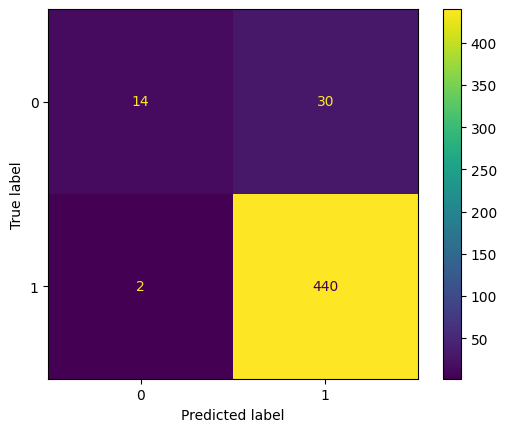

In [ ]:
# displaying confusion matrix for the problem
cm=confusion_matrix(y_test,y_pred)
cm_display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgb.classes_)
cm_display.plot()
plt.show()